# AutoML: Automating machine learning applied to areal regression modeling

This tutorial was presented [EO Council Opengeohub Summer School Wageningen 2025](https://opengeohub.org/summer-school/summer-school-2025) and is part of the projects: Open-Earth-Monitor Cyberinfrastructure (Grant No. [101059548](https://cordis.europa.eu/project/id/101059548/results) and the [Land & Carbon Global Pasture Watch[(https://landcarbonlab.org/about-global-pasture-watch/).

Key modeling aspects (see [presentation slides](https://docs.google.com/presentation/d/1qePs0puoVaVaVysztSlqLadb4_YIxQNf2JeuaF5GWlI)):
- **Livestock census data**: You will use a compilation of subnational livestock census data for the Brazilian [state Goiás](https://nl.wikipedia.org/wiki/Goiás_(staat)), which annual headcount estimates for cattle, goat, sheep, horse and buffalo at municipally levels (247 polygons),

- **Harmonized raster layers**: The raster layers are provided in different spatial/temporal resolutions and will be harmonized via [gdalbuildvrt](https://gdal.org/en/stable/programs/gdalbuildvrt.html), resulting in a standardized 1-km annual [data cube computed on-the-fly](https://gitlab.com/leal.parente/geo-snippets/-/blob/main/data_cubes/WRI_Summit_2023_Accessing_Imagery_Collections_Raster_Data_Cubes_STAC.ipynb?ref_type=heads),

- **Potential land for livestock production**: Raster layer representing the fraction of land (grassland & cropland combined) where the livestock animals obtain food. This layer will be used to select which pixel must be included in zonal statistics and estimate the total area used for livestock activity,

- **Spatiotemporal zonal statistics**: computation of spatial mean (all input features/covariates) and sum (potential land for livestock production) for each census polygon on a annual basis,

- **Spatiotemporal areal regression**: Train and evaluate (spatial cross-validation and 20% for test set) a default Random Forest regressor ([scikit-learn](https://scikit-learn.org/stable/)) and model selected by a AutoML ([EvalML](https://evalml.alteryx.com/en/stable/user_guide/automl.html)),

- **Spatiotemporal gridded prediction**: Use the harmonized raster layers and the trained models to predict gridded output with 1-km spatial resolution on a annual basis.

# Installing the libraries

First you need to install [scikit-map](https://github.com/openlandmap/scikit-map):

In [274]:
!pip install --upgrade "scikit-map[full]" 'git+https://github.com/openlandmap/scikit-map@eo-summer-school'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openlandmap/scikit-map (to revision eo-summer-school) to /tmp/pip-req-build-bcb8is8e
  Running command git clone --filter=blob:none --quiet https://github.com/openlandmap/scikit-map /tmp/pip-req-build-bcb8is8e
^C
ERROR: Operation cancelled by user


..and make sure that GDAL is installed in your operation system. If the following command fails, you need to find your way to [install GDAL](https://mapscaping.com/installing-gdal-for-beginners/).

In [277]:
!gdalinfo --version

GDAL 3.6.2, released 2023/01/02


In most of Debian based linux distribution, including ubuntu, GDAL can be installed by:

In [ ]:
!apt install -y gdal-bin

To have access to several functions used in this tutorial you need to download:

In [282]:
# Download file

...and import `misc.py`. If any library fails to load, you need to find your way to install it using [pip](https://pypi.org/project/pip/), [conda](https://anaconda.org/anaconda/conda) or [mamba](https://mamba.readthedocs.io/en/latest/user_guide/mamba.html):

In [1]:
import misc

You might need to install the following libraries:

In [ ]:
!pip install evalml

...and other necessary libraries:

In [2]:
import os
import misc
import numpy as np
import pandas as pd
import wget
import tarfile

from skmap.misc import ttprint
from pathlib import Path
from skmap import io

import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict

import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")
sns.set_context("notebook")

# Downloading census data and raster layers

All data necessary to run the modeling is organized in a compressed file, so let's download it using [wget](https://pypi.org/project/wget/):

In [307]:
#!pip install wget

In [3]:
base_url = 'https://s3.eu-central-1.wasabisys.com/ogh/tmp'
file = 'gitl'
wget.download(f'{base_url}/{file}')


KeyboardInterrupt



Now, let's extract it:

In [278]:
tar = tarfile.open(file)
tar.extractall()
tar.close()

# Loading census data

Let's load the subnational livestock census data:

In [4]:
polygon_fn = 'gpw_livestock.animals_ibge_polygon.samples_20000101_20241231_br.go_epsg.4326_v1.gpkg'

polygon_samples = gpd.read_file(polygon_fn)
polygon_samples

,gazID,gazName,country,level,source,buffalo_2000,buffalo_2001,buffalo_2002,buffalo_2003,buffalo_2004,...,sheep_2021,sheep_2022,sheep_2023,sheep_2024,cattle_nyears,goat_nyears,horse_nyears,sheep_nyears,buffalo_nyears,geometry
0,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,Brazil,3,GPW,NaN,NaN,NaN,NaN,NaN,...,110.0,130.0,NaN,NaN,24,24,24,24,12,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398..."
1,.002.003.003.009.002,Brazil.Goiás.Abadiânia,Brazil,3,GPW,40.0,40.0,45.0,50.0,60.0,...,684.0,694.0,NaN,NaN,24,24,24,24,23,"MULTIPOLYGON (((-48.61291 -16.14283, -48.60518..."
2,.002.003.003.009.003,Brazil.Goiás.Acreúna,Brazil,3,GPW,400.0,300.0,200.0,NaN,NaN,...,174.0,146.0,NaN,NaN,24,24,24,19,19,"MULTIPOLYGON (((-50.07360 -17.46149, -50.07881..."
3,.002.003.003.009.004,Brazil.Goiás.Adelândia,Brazil,3,GPW,12.0,11.0,12.0,13.0,15.0,...,50.0,6.0,NaN,NaN,24,14,24,14,23,"MULTIPOLYGON (((-50.13351 -16.33688, -50.13582..."
4,.002.003.003.009.005,Brazil.Goiás.Água Fria de Goiás,Brazil,3,GPW,30.0,34.0,NaN,NaN,NaN,...,1463.0,1582.0,NaN,NaN,24,24,24,24,12,"MULTIPOLYGON (((-47.57374 -15.04709, -47.67991..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,.002.003.003.009.254,Brazil.Goiás.IPIRANGA DE GOIÁS,Brazil,3,GPW,NaN,NaN,NaN,NaN,NaN,...,83.0,81.0,NaN,NaN,23,23,23,23,3,"MULTIPOLYGON (((-49.60871 -15.04302, -49.61117..."
243,.002.003.003.009.255,Brazil.Goiás.ITAJÁ,Brazil,3,GPW,215.0,220.0,225.0,227.0,220.0,...,1400.0,1470.0,NaN,NaN,24,24,24,24,23,"MULTIPOLYGON (((-51.64919 -18.79389, -51.64539..."
244,.002.003.003.009.256,Brazil.Goiás.LAGOA SANTA,Brazil,3,GPW,NaN,NaN,NaN,NaN,7.0,...,630.0,719.0,NaN,NaN,24,23,24,23,19,"MULTIPOLYGON (((-51.22211 -19.15881, -51.20879..."
245,.002.003.003.009.257,Brazil.Goiás.SILVÂNIA,Brazil,3,GPW,110.0,120.0,115.0,110.0,115.0,...,1300.0,1050.0,NaN,NaN,24,24,24,24,23,"MULTIPOLYGON (((-48.41155 -16.28667, -48.40971..."


...and check polygons:

<Axes: >

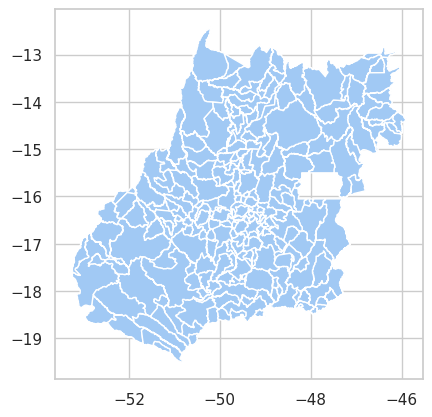

In [5]:
polygon_samples.plot()

# Harmonizing raster layers

In [6]:
livestock_covs = pd.read_csv(f'livestock_cov.csv')
livestock_covs

,url,type,start_year,end_year,layername,spatial_res
0,https://s3.opengeohub.org/global/dtm/v3/hillsh...,static,NaN,NaN,hillshade_edtm_m_960m_s_20000101_20221231_go_e...,960m
1,https://s3.opengeohub.org/global/dtm/v3/slope....,static,NaN,NaN,slope.in.degree_edtm_m_960m_s_20000101_2022123...,960m
2,https://s3.opengeohub.org/global/lcv/lcv_acces...,static,NaN,NaN,lcv_accessibility.to.cities_map.ox.var10_m_1km...,1km
3,https://s3.opengeohub.org/global/lcv/lcv_acces...,static,NaN,NaN,lcv_accessibility.to.cities_map.ox.var11_m_1km...,1km
4,https://s3.opengeohub.org/global/lcv/lcv_acces...,static,NaN,NaN,lcv_accessibility.to.cities_map.ox.var12_m_1km...,1km
5,https://s3.opengeohub.org/global/lcv/lcv_water...,static,NaN,NaN,lcv_water.occurance_jrc.surfacewater_p_250m_b0...,250m
6,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m01_m_1km_s_19700101_200...,1km
7,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m02_m_1km_s_19700101_200...,1km
8,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m03_m_1km_s_19700101_200...,1km
9,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m04_m_1km_s_19700101_200...,1km


In [7]:
livestock_covs['spatial_res'].unique()

array(['960m', '1km', '250m', '10km'], dtype=object)

In [8]:
livestock_covs['r_method'] = livestock_covs['spatial_res'].replace({
    '960m': 'near',
    '1km': 'near',
    '250m': 'average',
    '10km': 'cubicspline',
})

In [9]:
tr = '1000 1000'
t_srs = '+proj=igh +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'

ulx, lry, lrx, uly = polygon_samples.to_crs(t_srs).total_bounds
te = f'{ulx} {lry} {lrx} {uly}'

In [10]:
indir = 'raster_layers'
outdir = 'datacube'
end_year = 2022

os.makedirs(outdir, exist_ok=True)

with open(f"gen_datacube.in", "w") as outfile:
    cmds = misc.gdalwarp_cmds(livestock_covs, indir, outdir, end_year, te, tr, t_srs)
    for line in cmds:
        outfile.write(f"{line}\n")

print(f'Size: {len(cmds)}')
if len(cmds) > 0:
    print(f'First: {cmds[0]}')

Size: 0


# Spatiotemporal zonal statistics

In [11]:
base_path = 'datacube'
static_covs = [ l for l in livestock_covs[livestock_covs['type'] == 'static'].layername ]
temporal_covs = [ l for l in livestock_covs[livestock_covs['type'] == 'temporal'].layername ]

## Single polygon

In [325]:
polygon_samp = polygon_samples.iloc[0:1]

In [327]:
years = misc.extract_years(polygon_samp)

In [328]:
covs_info = misc.gen_covs_info(static_covs, temporal_covs, years, base_path)
covs_info

,path,type
0,datacube/hillshade_edtm_m_960m_s_20000101_2022...,static
1,datacube/slope.in.degree_edtm_m_960m_s_2000010...,static
2,datacube/lcv_accessibility.to.cities_map.ox.va...,static
3,datacube/lcv_accessibility.to.cities_map.ox.va...,static
4,datacube/lcv_accessibility.to.cities_map.ox.va...,static
...,...,...
703,datacube/veg_ndvi_mod13q1.v061_p50_250m_s0..0c...,2022
704,datacube/veg_ndvi_mod13q1.v061_p50_250m_s0..0c...,2022
705,datacube/veg_ndvi_mod13q1.v061_p50_250m_s0..0c...,2022
706,datacube/night.lights_dmsp.viirs_m_1km_s_20220...,2022


In [329]:
mask_filter = covs_info['path'].str.contains('grassland.cropland')
mask_info = covs_info[mask_filter].reset_index(drop=True)
covs_info = covs_info[np.logical_not(mask_filter)].reset_index(drop=True)

mask_info

,path,type
0,datacube/gpw_livestock.pot.land_grassland.crop...,2000
1,datacube/gpw_livestock.pot.land_grassland.crop...,2001
2,datacube/gpw_livestock.pot.land_grassland.crop...,2002
3,datacube/gpw_livestock.pot.land_grassland.crop...,2003
4,datacube/gpw_livestock.pot.land_grassland.crop...,2004
5,datacube/gpw_livestock.pot.land_grassland.crop...,2005
6,datacube/gpw_livestock.pot.land_grassland.crop...,2006
7,datacube/gpw_livestock.pot.land_grassland.crop...,2007
8,datacube/gpw_livestock.pot.land_grassland.crop...,2008
9,datacube/gpw_livestock.pot.land_grassland.crop...,2009


In [330]:
crs_igg = '+proj=igh +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'
window = misc.extract_window(polygon_samp, mask_info, crs_igg)
window

Window(col_off=397, row_off=480, width=18, height=16)

In [331]:
covs_data = io.read_rasters_cpp(covs_info['path'], window=window, verbose=True, n_jobs=8)

[08:38:23] Reading 685 layers using window=Window(col_off=397, row_off=480, width=18, height=16) and array=(685, 288)
[08:38:24] End


In [332]:
mask_data = io.read_rasters_cpp(mask_info['path'], window=window, verbose=True, n_jobs=8)

[08:38:24] Reading 23 layers using window=Window(col_off=397, row_off=480, width=18, height=16) and array=(23, 288)
[08:38:25] End


In [333]:
polygon_mask = misc.gen_polygon_mask(polygon_samp, mask_info, crs_igg)

In [334]:
n_jobs = 8
mask_ignore_val = 0
polygon_zonal = misc.spationtemporal_masked_zonal_mean(polygon_mask, covs_data, covs_info, mask_data, mask_info, mask_ignore_val, n_jobs, True)

[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2000
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2001
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2002
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2003
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2004
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2005
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2006
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2007
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2008
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2009
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2010
[08:38:27] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2011
[08:38:27] Calculating zonal

In [335]:
area_col = 'mask_km2'
polygon_zonal = polygon_zonal.rename(columns={'mask_sum':area_col})

# Adjusting scale factor used in the mask layer
polygon_zonal[area_col] = polygon_zonal[area_col] / 100

In [336]:
additional_cols = ['gazID','gazName','source']
animals = ['cattle','goat']

misc.merge_livestock_data(polygon_samp, polygon_zonal, animals, area_col, additional_cols)

,gazID,gazName,source,mask_km2,year,geometry,cattle_density,cattle_heads,goat_density,goat_heads,...,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.04.01..year.04.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.05.01..year.05.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.06.01..year.06.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.07.01..year.07.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.08.01..year.08.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.09.01..year.09.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.10.01..year.10.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.11.01..year.11.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.12.01..year.12.31_v2,night.lights_dmsp.viirs_m_1km_s_year0101_year1231_go_epsg4326_v1
0,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,108.21,2000,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",92.412901,10000.0,0.231032,25.0,...,7025.0,5811.0,4669.0,3984.0,4166.0,4710.0,5118.0,6372.0,6776.0,9.0
1,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,105.72,2001,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",145.762391,15410.0,0.283768,30.0,...,6690.0,6183.0,5443.0,4508.0,4106.0,4931.0,5891.0,6391.0,6830.0,7.0
2,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,107.11,2002,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",176.454113,18900.0,0.326767,35.0,...,6596.0,5818.0,4765.0,4067.0,3759.0,3868.0,4394.0,5302.0,6586.0,8.0
3,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,106.46,2003,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",139.958670,14900.0,0.375728,40.0,...,7006.0,6033.0,4879.0,4078.0,3944.0,4717.0,5677.0,6388.0,6674.0,8.0
4,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,105.22,2004,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",143.698917,15120.0,0.475195,50.0,...,6933.0,6479.0,5438.0,4564.0,3827.0,3671.0,5186.0,6575.0,6893.0,8.0
5,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,104.41,2005,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",154.965999,16180.0,0.574658,60.0,...,6844.0,6027.0,5101.0,4246.0,3751.0,4124.0,5452.0,6336.0,6714.0,9.0
6,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,102.55,2006,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",170.258411,17460.0,0.682594,70.0,...,7012.0,6124.0,5197.0,4296.0,3835.0,4185.0,6136.0,6529.0,6939.0,10.0
7,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,101.58,2007,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",146.091750,14840.0,0.787557,80.0,...,6633.0,6037.0,5103.0,4229.0,3730.0,3568.0,4737.0,5905.0,6727.0,10.0
8,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,101.26,2008,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",152.577523,15450.0,0.987557,100.0,...,7257.0,6678.0,5561.0,4487.0,3868.0,4297.0,5752.0,6609.0,7152.0,8.0
9,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,102.15,2009,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",158.590308,16200.0,1.174743,120.0,...,7141.0,6629.0,5722.0,4683.0,4597.0,5846.0,6665.0,7120.0,7093.0,7.0


## Multiple polygons

In [337]:
crs_igg = '+proj=igh +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'
n_jobs = 8
mask_ignore_val = 0
area_col = 'mask_km2'
additional_cols = ['gazID','gazName','source']
animals = ['cattle','goat']

livestock_data_arr = []

for _, polygon_samp in polygon_samples.sample(5).iterrows():
    ttprint(f"Processing {polygon_samp['gazName']}")
    polygon_samp = gpd.GeoDataFrame(
        pd.DataFrame([polygon_samp]),
        geometry='geometry',
        crs=polygon_samples.crs
    )
    
    years = misc.extract_years(polygon_samp)

    covs_info = misc.gen_covs_info(static_covs, temporal_covs, years, base_path)
    mask_filter = covs_info['path'].str.contains('grassland.cropland')
    mask_info = covs_info[mask_filter].reset_index(drop=True)
    covs_info = covs_info[np.logical_not(mask_filter)].reset_index(drop=True)

    window = misc.extract_window(polygon_samp, mask_info, crs_igg)
    covs_data = io.read_rasters_cpp(covs_info['path'], window=window, verbose=False, n_jobs=n_jobs)
    mask_data = io.read_rasters_cpp(mask_info['path'], window=window, verbose=False, n_jobs=n_jobs)
    polygon_mask = misc.gen_polygon_mask(polygon_samp, mask_info, crs_igg)
    polygon_zonal = misc.spationtemporal_masked_zonal_mean(polygon_mask, covs_data, covs_info, mask_data, mask_info, mask_ignore_val, n_jobs)

    polygon_zonal = polygon_zonal.rename(columns={'mask_sum':area_col})
    polygon_zonal[area_col] = polygon_zonal[area_col] / 100
    livestock_data = misc.merge_livestock_data(polygon_samp, polygon_zonal, animals, area_col, additional_cols)
    livestock_data_arr.append(livestock_data)
    
livestock_data = pd.concat(livestock_data_arr)

[08:38:39] Processing Brazil.Goiás.Chapadinha
[08:38:42] Processing Brazil.Goiás.Firminópolis
[08:38:43] Processing Brazil.Goiás.Santa Rita do Novo destino
[08:38:45] Processing Brazil.Goiás.Alto Paraíso de Goiás
[08:38:46] Processing Brazil.Goiás.Nazário


# Spatiotemporal areal regression

In [12]:
livestock_data = pd.read_parquet('gpw_livestock.animals_ibge_zonal.samples_20000101_20241231_br.go_epsg.4326_v1.pq')
livestock_data

,gazID,gazName,source,mask_km2,year,cattle_density,cattle_heads,goat_density,goat_heads,hillshade_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230,...,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.04.01..year.04.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.05.01..year.05.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.06.01..year.06.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.07.01..year.07.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.08.01..year.08.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.09.01..year.09.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.10.01..year.10.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.11.01..year.11.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.12.01..year.12.31_v2,night.lights_dmsp.viirs_m_1km_s_year0101_year1231_go_epsg4326_v1
0,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,108.21,2000,92.412901,10000.0,0.231032,25.0,16551.0,...,7025.0,5811.0,4669.0,3984.0,4166.0,4710.0,5118.0,6372.0,6776.0,9.0
1,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,105.72,2001,145.762391,15410.0,0.283768,30.0,16551.0,...,6690.0,6183.0,5443.0,4508.0,4106.0,4931.0,5891.0,6391.0,6830.0,7.0
2,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,107.11,2002,176.454113,18900.0,0.326767,35.0,16551.0,...,6596.0,5818.0,4765.0,4067.0,3759.0,3868.0,4394.0,5302.0,6586.0,8.0
3,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,106.46,2003,139.958670,14900.0,0.375728,40.0,16551.0,...,7006.0,6033.0,4879.0,4078.0,3944.0,4717.0,5677.0,6388.0,6674.0,8.0
4,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,105.22,2004,143.698917,15120.0,0.475195,50.0,16551.0,...,6933.0,6479.0,5438.0,4564.0,3827.0,3671.0,5186.0,6575.0,6893.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,128.76,2018,222.506990,28650.0,0.240758,31.0,16262.0,...,7619.0,6789.0,5559.0,4586.0,4197.0,4531.0,6665.0,7447.0,7571.0,0.0
19,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,129.48,2019,225.903614,29250.0,0.254866,33.0,16262.0,...,7706.0,7279.0,6155.0,4917.0,4152.0,4027.0,5551.0,7056.0,7470.0,0.0
20,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,130.97,2020,228.296556,29900.0,0.267237,35.0,16262.0,...,7693.0,7259.0,6161.0,5133.0,4339.0,4098.0,5760.0,7264.0,7585.0,1.0
21,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,127.15,2021,245.379473,31200.0,0.298860,38.0,16262.0,...,7335.0,6316.0,5372.0,4399.0,3891.0,3866.0,5843.0,7213.0,7520.0,0.0


In [13]:
animal = 'cattle'

## Outlier removal

In [14]:
col_density = f'{animal}_density'
livestock_data.loc[:, f'{animal}_ind'] = np.logical_not(livestock_data[col_density].isnull()).astype('int')

cattle        cattle_density
0.000             4.0
0.010            26.0
0.020            32.0
0.030            37.0
0.040            40.0
0.050            45.0
0.500           137.0
0.950           241.0
0.975           282.0
0.980           303.0
0.990           419.0
1.000          1997.0


<Axes: ylabel='Frequency'>

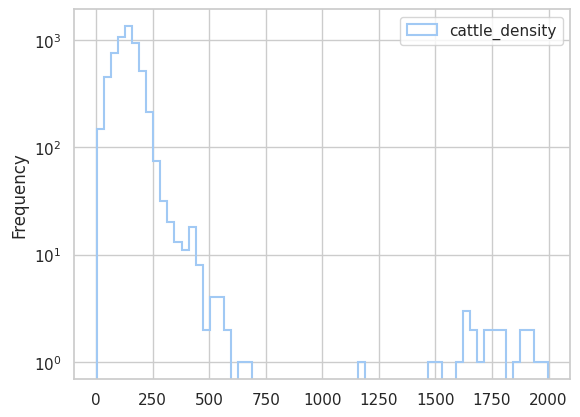

In [15]:
col_density = f'{animal}_density'

print(animal, livestock_data[np.logical_and.reduce([
    livestock_data[col_density] > 0.001
])][[col_density]].quantile(q=[0.0,0.01,0.02,0.03,0.04,0.05,0.5,0.95,0.975,0.98,0.99,1.0]).round())

livestock_data[[col_density]].plot(kind='hist', bins=64,  histtype='step', linewidth=1.5, log=True, legend=True)

In [16]:
zero_val = 0.001

col_density = f'{animal}_density'
col_ind = f'{animal}_ind'

n_samples = np.sum(livestock_data[col_ind] == 1)

mask = np.logical_and.reduce([
    livestock_data[col_ind] == 1,
    livestock_data[col_density] > 0
])

#q02 = livestock_data[mask][col_density].quantile(0.02)
#q02_mask = np.logical_and.reduce([
#    livestock_data[col_ind] == 1,
#    livestock_data[col_density] <= q02
#])

#print(animal, (np.sum(q02_mask) / n_samples) * 100, q02)
#livestock_data.loc[q02_mask,col_density] = zero_val

q98 = livestock_data[mask][col_density].quantile(0.99)
q98_mask = np.logical_not(np.logical_and.reduce([
    livestock_data[col_ind] == 1,
    livestock_data[col_density] >= q98
]))

print(animal, (np.sum(q98_mask) / n_samples) * 100, q98)
livestock_data = livestock_data[q98_mask]

cattle 98.9961253962663 419.43930253346696


## Train/test split

In [17]:
test_pct = 0.2

uniq_names = livestock_data['gazName'].unique()
n_names = len(uniq_names)
n_test_names = int(n_names * test_pct)

test_names = uniq_names[np.random.randint(n_names, size=n_test_names)]
print(f"Number municipalities for test: {n_test_names}")
print(test_names)

Number municipalities for test: 49
['Brazil.Goiás.Piranhas' 'Brazil.Goiás.Bom Jesus de Goiás'
 'Brazil.Goiás.Moiporá' 'Brazil.Goiás.Caçu'
 'Brazil.Goiás.São Miguel do Passa Quatro' 'Brazil.Goiás.Damianópolis'
 'Brazil.Goiás.Santa Filomena do Maranhão' 'Brazil.Goiás.Abadiânia'
 'Brazil.Goiás.CAMPO LIMPO DE GOIÁS' 'Brazil.Goiás.Itapirapuã'
 'Brazil.Goiás.Adelândia' 'Brazil.Goiás.Crixás' 'Brazil.Goiás.Aragoiânia'
 'Brazil.Goiás.Campinorte' 'Brazil.Goiás.São Simão'
 'Brazil.Goiás.Amaralina' 'Brazil.Goiás.Hidrolândia' 'Brazil.Goiás.Caçu'
 'Brazil.Goiás.Guarani de Goiás' 'Brazil.Goiás.Orizona'
 'Brazil.Goiás.Goiás' 'Brazil.Goiás.Taquaral de Goiás'
 'Brazil.Goiás.Amaralina' 'Brazil.Goiás.Corumbá de Goiás'
 'Brazil.Goiás.Santa Rita de Araguaia' 'Brazil.Goiás.CAMPO LIMPO DE GOIÁS'
 'Brazil.Goiás.Campinorte' 'Brazil.Goiás.Pilar de Goiás'
 'Brazil.Goiás.Caturaí' 'Brazil.Goiás.Novo Planalto'
 'Brazil.Goiás.Campinaçu' 'Brazil.Goiás.Castelândia'
 'Brazil.Goiás.Nova Veneza' 'Brazil.Goiás.Mineiros'
 '

In [19]:
livestock_data.loc[:,'ml_type'] = 'train'
livestock_data.loc[livestock_data['gazName'].isin(test_names), 'ml_type'] = 'test'
livestock_data['ml_type'].value_counts()

ml_type
train    4687
test      934
Name: count, dtype: int64

In [20]:
train_mask = (livestock_data['ml_type'] == 'train')
test_mask = (livestock_data['ml_type'] == 'test')

## Random Forest regressor

In [21]:
covs = list(livestock_data.columns[9:-2])
target = 'cattle_density'
group_col = 'gazName'
cv_folds = 5

In [22]:
pred_cv = cross_val_predict(
    RandomForestRegressor(criterion='poisson', n_jobs=-1), 
    livestock_data[train_mask][covs], 
    livestock_data[train_mask][target], 
    n_jobs = cv_folds, 
    groups = livestock_data[train_mask][group_col], 
    verbose = True,
    cv = GroupKFold(cv_folds)
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s finished


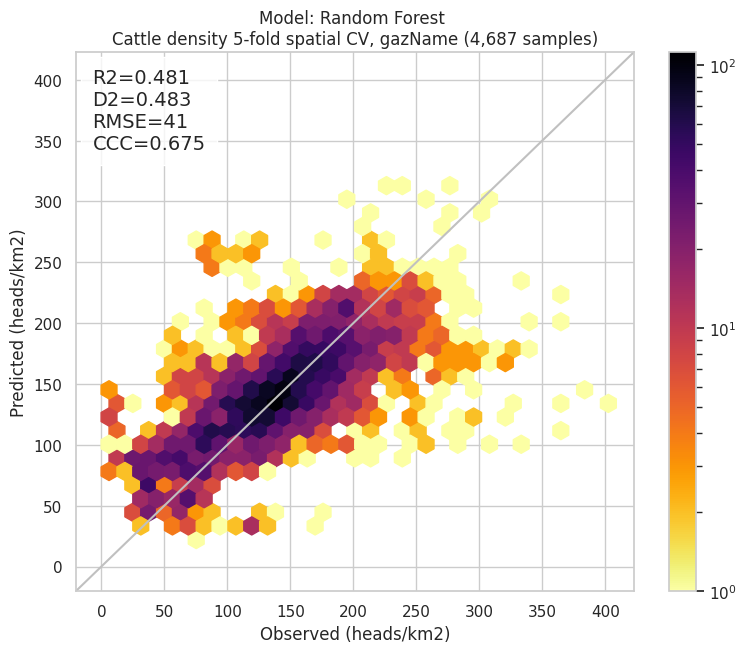

In [26]:
cv_df = pd.DataFrame({'pred':pred_cv, 'true':livestock_data[train_mask][target], 'weight': 1})

title_base=f'{animal.capitalize()} density 5-fold spatial CV, {group_col}'
misc.density_plot(cv_df, 'Random Forest', title_base=title_base, unit='heads/km2')

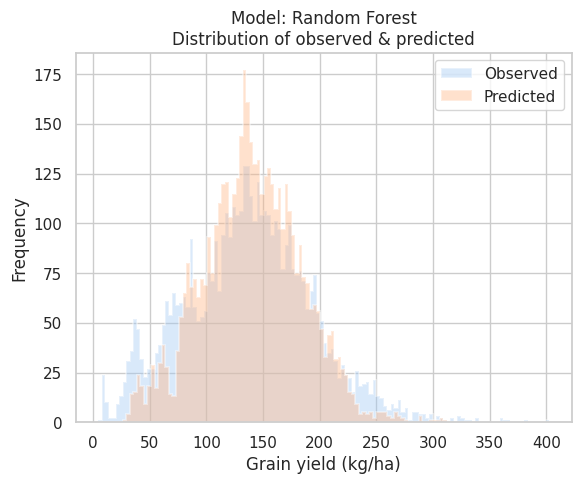

In [27]:
misc.histogram_plot(cv_df, 'Random Forest')

In [28]:
rf = RandomForestRegressor(criterion='poisson', n_jobs=-1)

rf.fit(livestock_data[train_mask][covs], livestock_data[train_mask][target]) 

test = rf.predict(livestock_data[test_mask][covs])

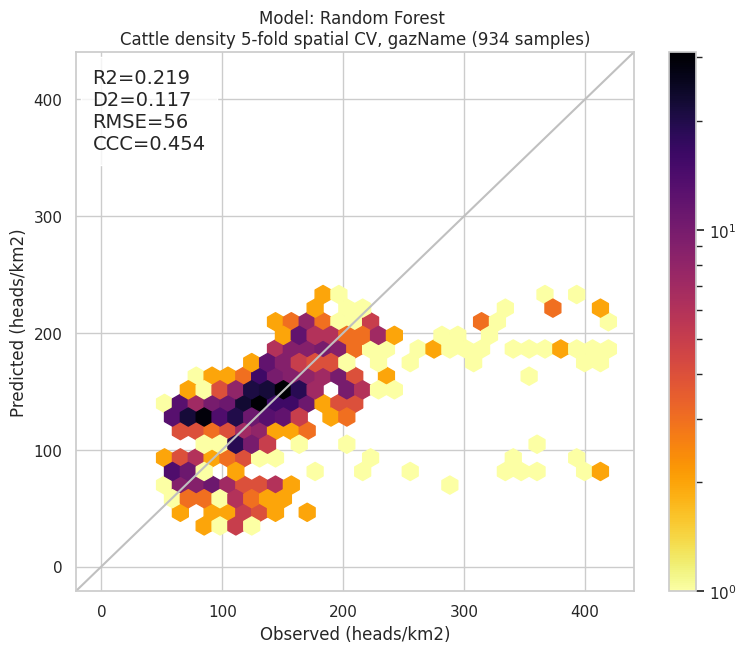

In [30]:
test_df = pd.DataFrame({'pred':test, 'true':livestock_data[test_mask][target], 'weight': 1})

title_base=f'{animal.capitalize()} density 5-fold spatial CV, {group_col}'
misc.density_plot(test_df, 'Random Forest', title_base=title_base, unit='heads/km2')

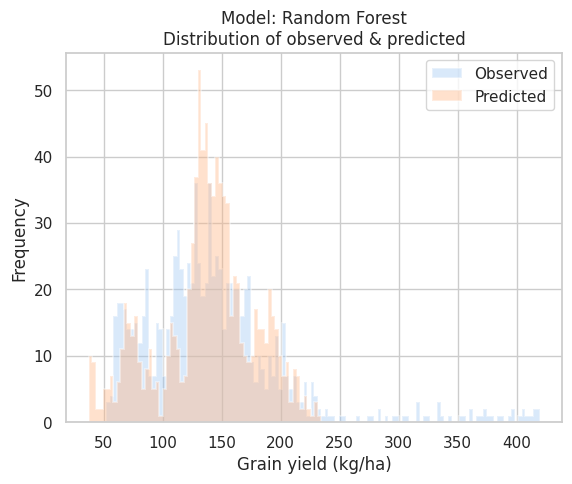

In [32]:
misc.histogram_plot(test_df, 'Random Forest')

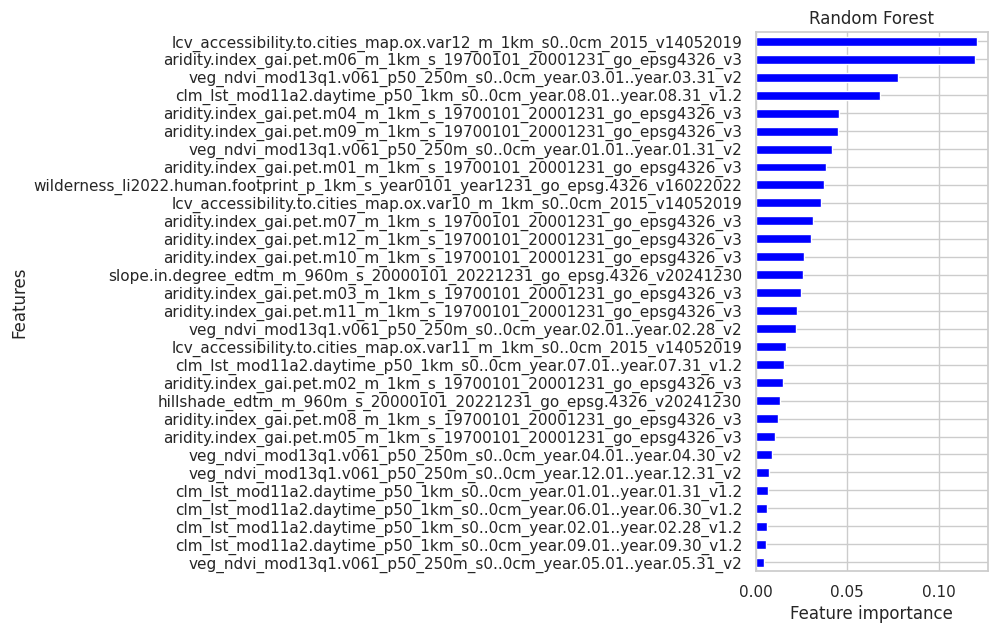

In [33]:
misc.importance_plot(rf.feature_names_in_, rf.feature_importances_, title="Random Forest")

## Auto-ML model

In [34]:
from evalml.problem_types import detect_problem_type
from evalml.automl import get_default_primary_search_objective

problem_type = detect_problem_type(livestock_data[target]).name

search_params = {
    'X_train': livestock_data[train_mask][covs],
    'y_train': livestock_data[train_mask][target],
    'X_holdout': livestock_data[test_mask][covs],
    'y_holdout': livestock_data[test_mask][target],
    'problem_type': problem_type,
    'objective': get_default_primary_search_objective(problem_type),
    'optimize_thresholds': True,
    'verbose': True,
    'max_iterations': 10
}

2025-09-04 09:06:52,939 featuretools - WARNING    Featuretools failed to load "premium_primitives" primitives from "premium_primitives". For a full stack trace, set logging to debug.


In [35]:
from evalml import AutoMLSearch

automl = AutoMLSearch(**search_params)
automl.search(interactive_plot=True)

AutoMLSearch will use the holdout set to score and rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for R2. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 10 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type': 'scatter',
              'uid': '3d93f48d-7cfb-45d4-900e-c880b7a11088',
              'x': [],
              'y': []},
             {'marker': {'color': 'gray'},
              'mode': 'markers',
              'name': 'Iter score',
              'type': 'scatter',
              'uid': '41122b96-c19b-461b-aacc-b29091883e85',
              'x': [],
              'y': []}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': ('Pipeline Search: Iteration vs.' ... 'ore at current iteration</sub>')},
               'xaxis': {'rangemode': 'tozero', 'title': {'text': 'Iteration'}},
               'yaxis': {'title': {'text': 'Validation Score'}}}
})

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean R2: -0.000
	Starting holdout set scoring
	Finished holdout set scoring - R2: -0.011

*****************************
* Evaluating Batch Number 1 *
*****************************

Random Forest Regressor w/ Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean R2: 0.794
	Starting holdout set scoring
	Finished holdout set scoring - R2: 0.162

*****************************
* Evaluating Batch Number 2 *
*****************************

Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean R2: 0.581
	Starting holdout set scoring
	Finished holdout set scoring - R2: 0.274
XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean R2: 0.859
	Starting holdout set sc

{1: {'Random Forest Regressor w/ Imputer + RF Regressor Select From Model': 3.703805685043335,
  'Total time of batch': 3.8403260707855225},
 2: {'Extra Trees Regressor w/ Imputer + Select Columns Transformer': 1.9165675640106201,
  'XGBoost Regressor w/ Imputer + Select Columns Transformer': 3.6957876682281494,
  'LightGBM Regressor w/ Imputer + Select Columns Transformer': 1.1236317157745361,
  'Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer': 1.8639798164367676,
  'Total time of batch': 9.11340856552124},
 3: {'Extra Trees Regressor w/ Imputer + Select Columns Transformer': 5.158289670944214,
  'LightGBM Regressor w/ Imputer + Select Columns Transformer': 1.1497104167938232,
  'Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer': 1.3003087043762207,
  'Total time of batch': 12.922730445861816}}

In [36]:
automl.rankings

,id,pipeline_name,search_order,ranking_score,holdout_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,6,Extra Trees Regressor w/ Imputer + Select Colu...,6,0.321924,0.321924,0.751552,0.019567,221468.776548,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,8,Elastic Net Regressor w/ Imputer + Standard Sc...,8,0.260421,0.260421,0.415005,0.007705,122339.229250,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,4,LightGBM Regressor w/ Imputer + Select Columns...,4,0.246232,0.246232,0.799421,0.013640,235568.621492,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,3,XGBoost Regressor w/ Imputer + Select Columns ...,3,0.242463,0.242463,0.859073,0.015593,253138.985927,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,1,Random Forest Regressor w/ Imputer + RF Regres...,1,0.161678,0.161678,0.794112,0.023120,234004.611183,False,{'Imputer': {'categorical_impute_strategy': 'm...
9,0,Mean Baseline Regression Pipeline,0,-0.010544,-0.010544,-0.000340,0.000294,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


In [37]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


*****************************************************************
* Extra Trees Regressor w/ Imputer + Select Columns Transformer *
*****************************************************************

Problem Type: regression
Model Family: Extra Trees

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : knn
	 * boolean_impute_strategy : most_frequent
	 * categorical_fill_value : None
	 * numeric_fill_value : None
	 * boolean_fill_value : None
2. Select Columns Transformer
	 * columns : ['hillshade_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230', 'slope.in.degree_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230', 'lcv_accessibility.to.cities_map.ox.var10_m_1km_s0..0cm_2015_v14052019', 'lcv_accessibility.to.cities_map.ox.var12_m_1km_s0..0cm_2015_v14052019', 'aridity.index_gai.pet.m01_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m02_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m03_m_

In [38]:
best_pipeline = automl.best_pipeline

In [39]:
test = automl.best_pipeline.predict(livestock_data[test_mask][covs])

In [40]:
model_name = automl.rankings.iloc[0]["pipeline_name"]
model_name

'Extra Trees Regressor w/ Imputer + Select Columns Transformer'

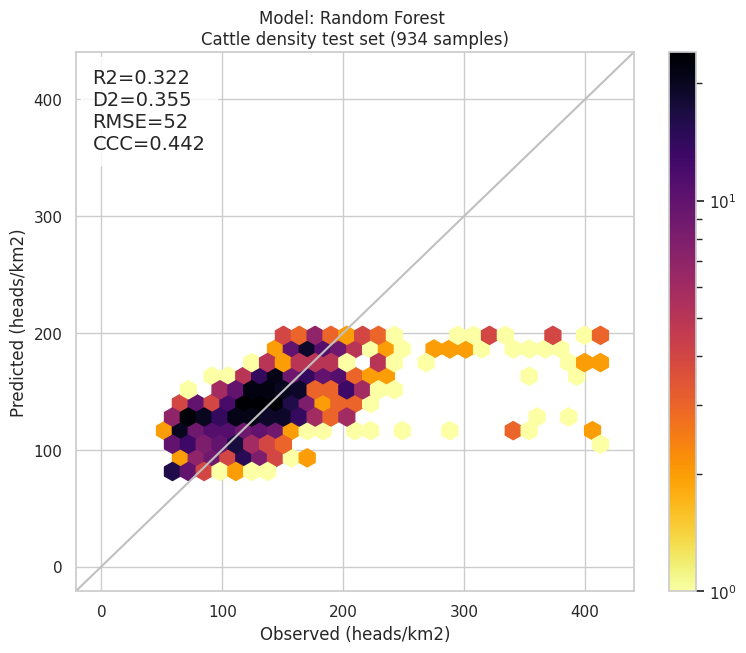

In [44]:
test_df = pd.DataFrame({'pred':test, 'true':livestock_data[test_mask][target], 'weight': 1})
title_base=f'{animal.capitalize()} density test set'
misc.density_plot(test_df, 'Random Forest', title_base=title_base, unit='heads/km2')

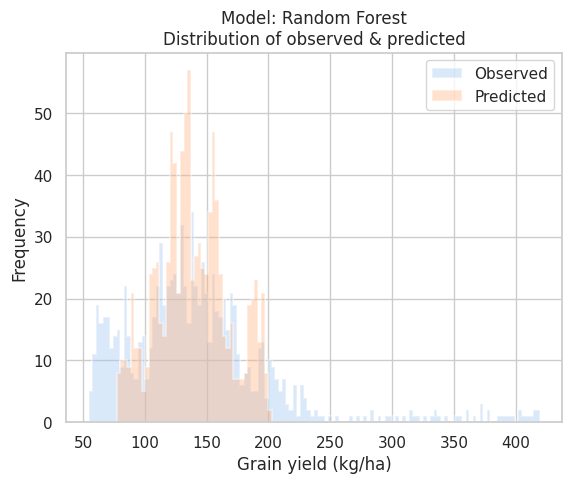

In [45]:
misc.histogram_plot(test_df, 'Random Forest')

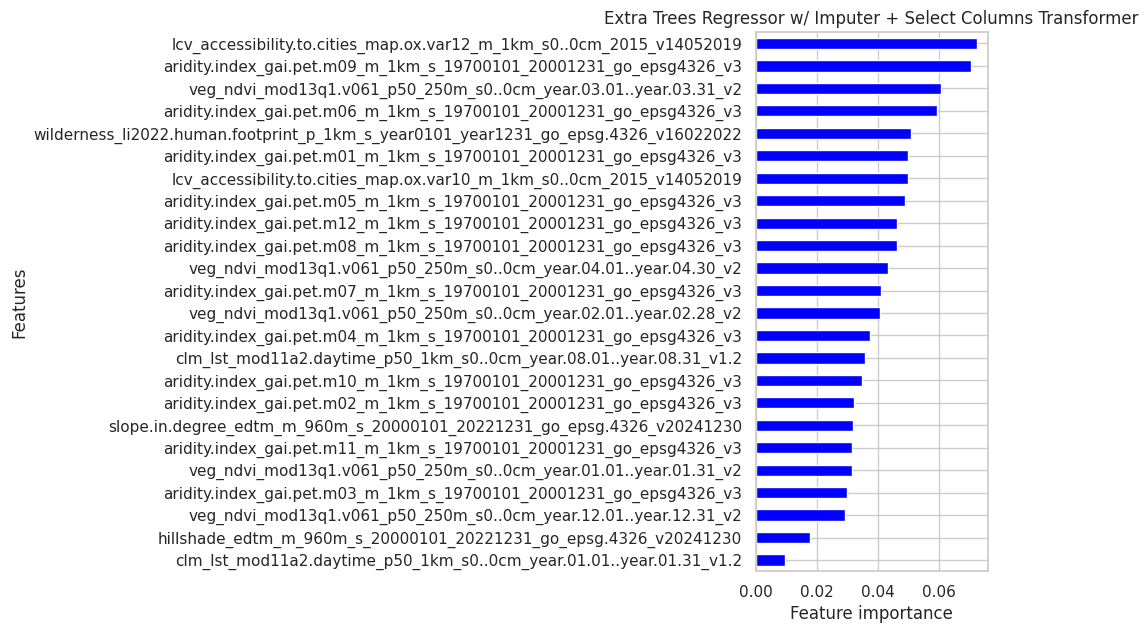

In [47]:
misc.importance_plot(best_pipeline.feature_importance.feature, best_pipeline.feature_importance.importance, 
             title=automl.rankings.iloc[0]["pipeline_name"])

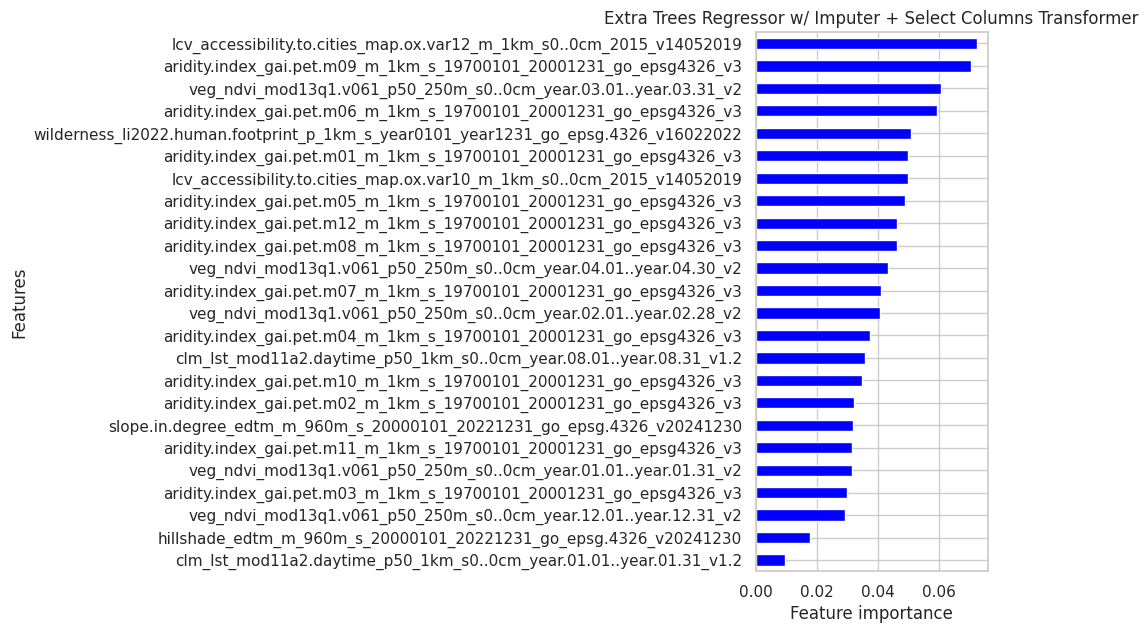

In [48]:
misc.importance_plot(best_pipeline.feature_importance.feature, best_pipeline.feature_importance.importance, 
             title=model_name)

## Spatiotemporal prediction

### Loading harmonized layer

In [51]:
year = 2020
n_jobs=8

In [ ]:
covs_info = misc.gen_covs_info(static_covs, temporal_covs, [year], base_path)
mask_filter = covs_info['path'].str.contains('grassland.cropland')
mask_info = covs_info[mask_filter].reset_index(drop=True)
covs_info = covs_info[np.logical_not(mask_filter)].reset_index(drop=True)

covs_data = io.read_rasters_cpp(covs_info['path'], verbose=True, n_jobs=n_jobs)

In [ ]:
mask_data = io.read_rasters_cpp(mask_info['path'], verbose=True, n_jobs=n_jobs)

### Prepare input data

In [ ]:
pred_mask = np.logical_and.reduce([
    mask_data[0,:] > 0,
    np.logical_not(np.any(np.isnan(covs_data), axis=0))
])
pred_in = covs_data.T[pred_mask]

### Random Forest prediction

In [ ]:
rf_density = np.empty((pred_mask.shape[0],1), dtype='float32')
rf_density[pred_mask,0] = rf.predict(pred_in)
rf_density = np.array(rf_density.T)

In [ ]:
rf_headcount = (mask_data / 100) * rf_density

In [ ]:
io.save_rasters_cpp(covs_info['path'][0], rf_density, f'rf_{animal}_density_{year}', dtype = np.uint16, nodata=0)

In [ ]:
io.save_rasters_cpp(covs_info['path'][0], rf_headcount, f'rf_{animal}_headcount_{year}', dtype = np.uint16, nodata=0)

### AutoML prediction

In [ ]:
pred_in_df = pd.DataFrame(pred_in, columns=covs)
print(f"Model input shape: {data.shape}")

In [ ]:
# AutoML
aml_density = np.empty((pred_mask.shape[0],1), dtype='float32')
aml_density[pred_mask,0] = best_pipeline.predict(pred_in_df)
aml_density = np.array(aml_density.T)

In [ ]:
aml_headcount = (mask_data / 100) * aml_density

In [ ]:
io.save_rasters_cpp(covs_info['path'][0], pred_out, f'aml_{animal}_density_{year}', dtype = np.uint16, nodata=0)

In [ ]:
io.save_rasters_cpp(covs_info['path'][0], headcount, f'aml_{animal}_headcount_{year}', dtype = np.uint16, nodata=0)